In [1]:
### Our universal functions
import MLmodels as m

### basic imports 
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import math
import seaborn

### sklearn model
import sklearn.ensemble as ske
import sklearn.tree as skt
import sklearn.preprocessing as pre

##roc/auc
#from sklearn.metrics import roc_auc_score
## note online sklearn seemed to have plot_roc_curve, but I just found this one
##   I probably need to update my system!!
#from sklearn.metrics import roc_curve

import sklearn.metrics as skmet
import sklearn.model_selection as skms

## fit simple logit
# import statsmodels.api as sm

In [2]:
scl = pre.StandardScaler()
ode = pre.OrdinalEncoder()
ohe = pre.OneHotEncoder(sparse=False)

types = "HCLT.HCRT.HCB20T.HCGLT.HCGRT.HCGB20T".split(".")

# just preppin data
datatype1 = types[3]
datatype2 = types[4]
datatype3 = types[5]

train1, validate1, weights1 = m.get_rawdata(datatype1, 10, 10, round=8, outputnum=2)
train2, validate2, weights2 = m.get_rawdata(datatype2, 10, 10, round=8, outputnum=2)
train3, validate3, weights3 = m.get_rawdata(datatype3, 10, 5, round=8, outputnum=2)
# weights for certain loss functions, we can ignore it


for x in [train1, train2, train3, validate1, validate2, validate3]:
    x["binary"] = x["affinity"].apply(m.bi_labelM)
    

def process(dataset):
    trial = list(dataset.sequence.to_numpy())
    full = np.asarray([list(x) for x in trial])
    return full


Xtrain1 = ohe.fit_transform(process(train1))
Xtrain2 = ohe.transform(process(train2))
Xtrain3 = ohe.transform(process(train3))

Ytrain1 = train1['binary'].to_numpy()[:, np.newaxis]
Ytrain2 = train2['binary'].to_numpy()[:, np.newaxis]
Ytrain3 = train3['binary'].to_numpy()[:, np.newaxis]

Xval1 = ohe.transform(process(validate1))
Xval2 = ohe.transform(process(validate2))
Xval3 = ohe.transform(process(validate3))

Yval1 = validate1['binary'].to_numpy()[:, np.newaxis]
Yval2 = validate2['binary'].to_numpy()[:, np.newaxis]
Yval3 = validate3['binary'].to_numpy()[:, np.newaxis]


def get_testset(datatype):
    seqdict = m.test_set_corr
    seqs = list(seqdict.keys())
    labels = np.asarray(list(seqdict.values()))[:, np.newaxis]
    tmp = np.asarray([list(x) for x in seqs])
    oh = ohe.transform(tmp)
    return seqs, oh, labels

def get_dcaset():
    seqdict = m.dca_test_set_corr
    seqs = list(seqdict.keys())
    labels = np.asarray(list(seqdict.values()))[:, np.newaxis]
    tmp = np.asarray([list(x) for x in seqs])
    oh = ohe.transform(tmp)
    return seqs, oh, labels

def myrmse(y,yhat):
   rmse = math.sqrt(skmet.mean_squared_error(y,yhat))
   return(np.round(rmse,3))


def confusion_matrix(y_true, y_pred):
    y_true = y_true.astype('bool').tolist()
    y_pred = y_pred.astype('bool').tolist()
    cm = skmet.confusion_matrix(y_true, y_pred, normalize = 'true')
    df_cm = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
    plt.figure(figsize=(10, 7))
    ax = plt.subplot()
    seaborn.set(font_scale=3.0)
    seaborn.heatmap(df_cm, annot=True, ax=ax)
    label_font = {'size': '26'}
    ax.tick_params(axis='both', which='major', labelsize=40)
    ax.xaxis.set_ticklabels(["0", "1"])
    ax.yaxis.set_ticklabels(["0", "1"])
    # plt.title(title)
    plt.show()
    plt.close()
    
def acc(y_true, y_pred):
    score = np.asarray([1 if x == y_pred[xid] else 0 for xid, x in enumerate(y_true)])
    ver_acc = np.mean(score)
    return ver_acc

In [3]:
tmp = types[1]
print(tmp)
s, o, l = get_testset(tmp)
print(len(s[0]), len(o[0]),o[0])

HCRT
20 80 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0.]


In [4]:
print(Xtrain1.shape, Xtrain2.shape, Xtrain3.shape)
print(Ytrain1.shape, Ytrain2.shape, Ytrain3.shape)
print(Xval1.shape, Xval2.shape, Xval3.shape)
print(Yval1.shape, Yval2.shape, Yval3.shape)
print(Xtrain1.shape[0])

(79783, 80) (81411, 80) (87450, 80)
(79783, 1) (81411, 1) (87450, 1)
(26290, 80) (27225, 80) (29664, 80)
(26290, 1) (27225, 1) (29664, 1)
79783


In [5]:
pos = np.count_nonzero(Ytrain1)
print(pos/Ytrain1.shape[0])

0.09090909090909091


# Try Single Tree First

In [3]:
def train_tree(dataset_num):

    print(f"##Single Tree Dataset {dataset_num}##")
    Xtrain = {1: Xtrain1, 2: Xtrain2, 3:Xtrain3}[dataset_num]
    Xval = {1: Xval1, 2: Xval2, 3:Xval3}[dataset_num]
    Ytrain = {1: Ytrain1, 2: Ytrain2, 3:Ytrain3}[dataset_num]
    Yval = {1: Yval1, 2: Yval2, 3:Yval3}[dataset_num]
    # fit on train, predict on val
    print("trained on training, predicted validation")
    gbm = skt.DecisionTreeRegressor(max_leaf_nodes=250)
    gbm.fit(Xtrain,Ytrain)
    ytrainboost = gbm.predict(Xval)

    ## plot boosting prediction on val
#     plt.scatter(ytrainboost,Yval,c='blue',s=.5)
#     plt.xlabel('yhat on validation from single tree on train');plt.ylabel('validation y')
#     plt.show()
    #print('rmse on val from Single Tree: ',myrmse(Yval,ytrainboost))
    print('acc on val from single tree: ',acc(Yval.astype('bool'),ytrainboost.astype('bool')))
    
    seqs, Xtest, Ytest = get_testset(types[dataset_num])
    #print('Xtest', Xtest.shape)
    confusion_matrix(Yval, ytrainboost)
    
    
    ##################################################
    ### let's fit gb on train+val, predict on test
    print("trained on training + val, predicted test")
    ## use train and val data
    x12 = np.vstack([Xtrain, Xval])
    y12 = np.concatenate([Ytrain, Yval])
    
    #print(x12, y12)
    gbm.fit(x12,y12)
    yhgb3 = gbm.predict(Xtest)
    #print('rmse on test from single tree: ',myrmse(Ytest,yhgb3))
    print('acc on test from single tree: ',acc(Ytest.astype('bool'), yhgb3.astype('bool')))

    ## plot predictions on test
#     plt.scatter(Ytest,yhgb3,c='green',s=.5)
#     plt.xlabel('test y')
#     plt.ylabel('test predictions from single tree on train+val')
#     plt.show()

    dcaseqs, Xdca, Ydca = get_dcaset()
    ydca = gbm.predict(Xdca)
    print('acc on dca set from single tree: ',acc(Ydca.astype('bool'), ydca.astype('bool')))
    Ytest = np.asarray(Ytest, dtype="bool")
    Ydca = np.asarray(Ydca, dtype="bool")
    ydca = np.asarray(ydca, dtype="bool")
    yhgb3 = np.asarray(yhgb3, dtype="bool")
    f1_test = skmet.f1_score(Ytest, yhgb3)
    f1_dca = skmet.f1_score(Ydca, ydca)
    confusion_matrix(Ydca, ydca)
    f1_mean = (23*f1_test +16*f1_dca)/(23+16)
    print("F1_Mean", f1_mean)
    
    confusion_matrix(Ytest, yhgb3)
    
    #skmet.plot_confusion_matrix()
    



##Single Tree Dataset 1##
trained on training, predicted validation
acc on val from single tree:  0.999581589958159


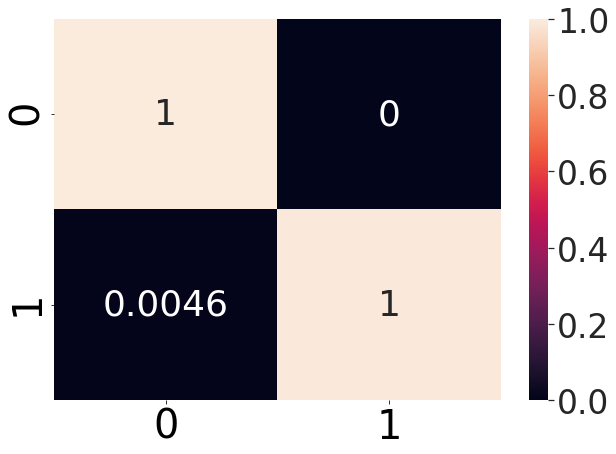

trained on training + val, predicted test
acc on test from single tree:  0.7037037037037037
acc on dca set from single tree:  0.8125


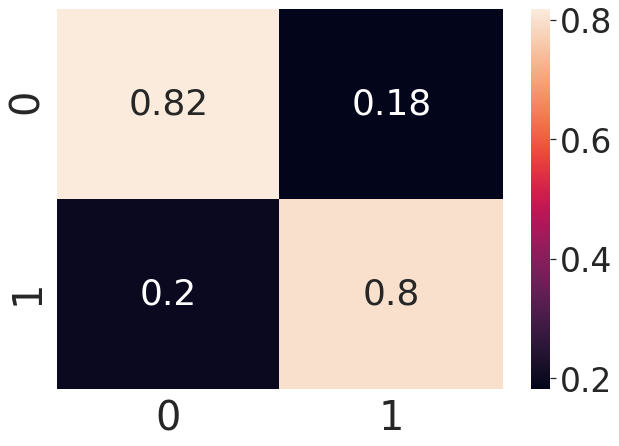

F1_Mean 0.7639553429027112


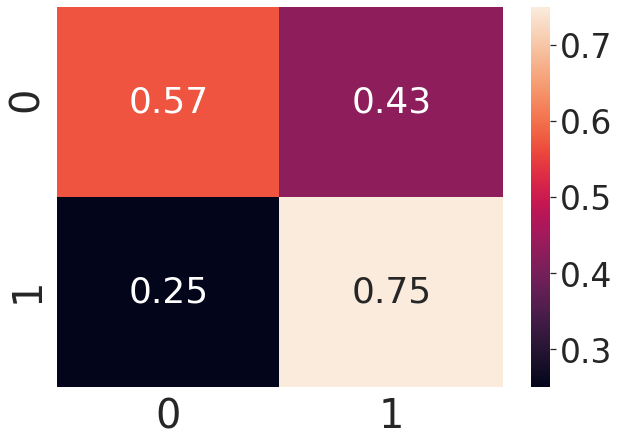

In [4]:
train_tree(1)
#train_tree(2)
#train_tree(3)  

##Single Tree Dataset 2##
trained on training, predicted validation
acc on val from single tree:  0.9993021120293848


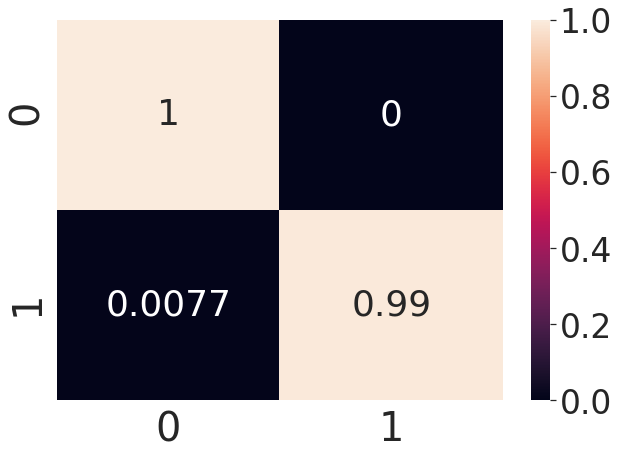

trained on training + val, predicted test
acc on test from single tree:  0.8518518518518519
acc on dca set from single tree:  0.8125


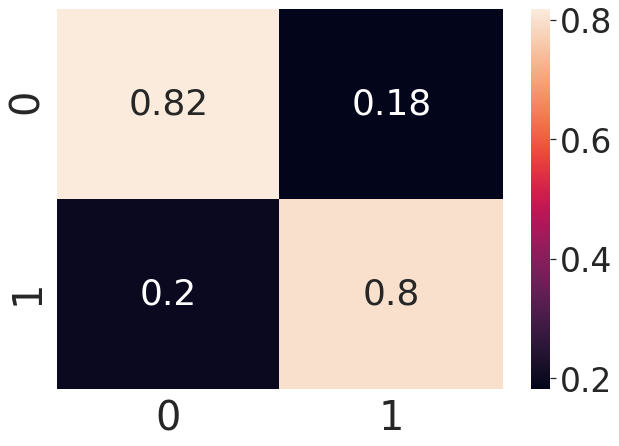

F1_Mean 0.8319458319458318


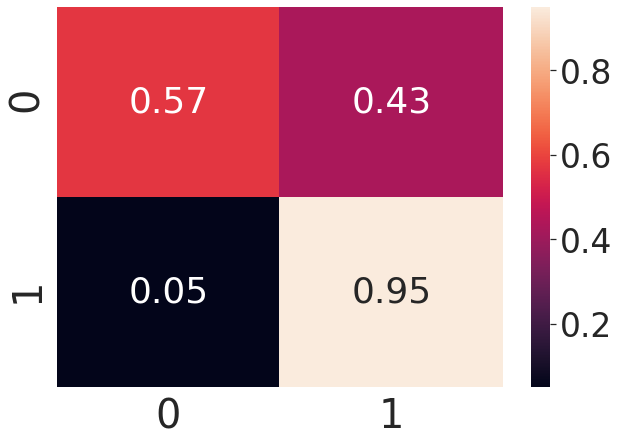

In [5]:
train_tree(2)

##Single Tree Dataset 3##
trained on training, predicted validation
acc on val from single tree:  0.9756944444444444


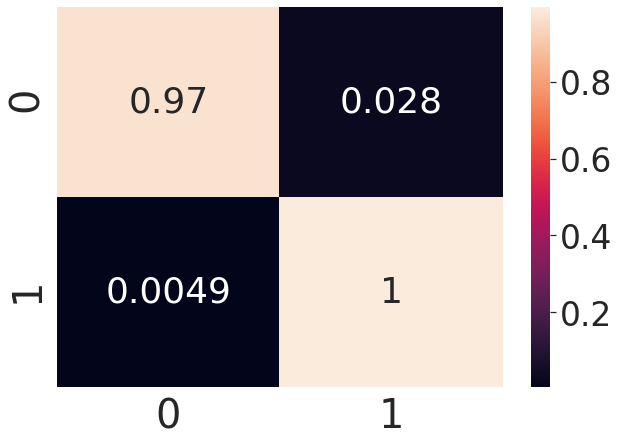

trained on training + val, predicted test
acc on test from single tree:  0.8888888888888888
acc on dca set from single tree:  0.625


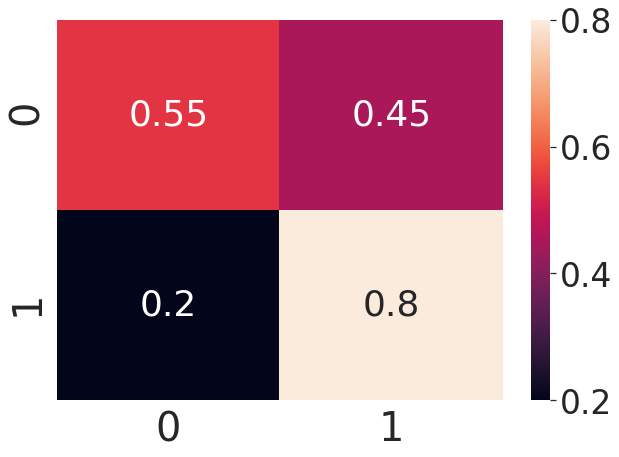

F1_Mean 0.7810238541945859


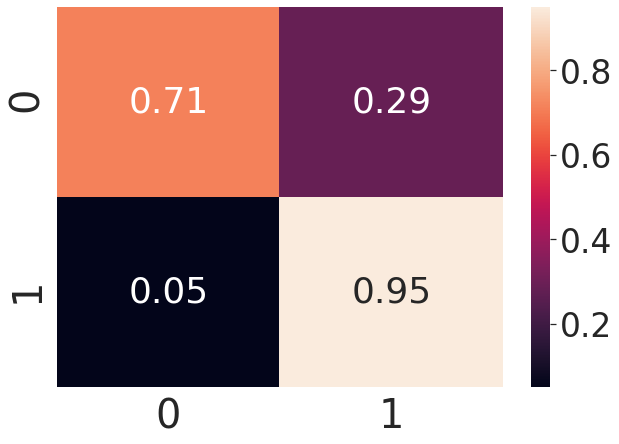

In [6]:
#train_tree(2)
train_tree(3)

In [10]:
def train_randomforest(datanum):
    print(f"##Random Forest Dataset: {datanum}##")
    Xtrain = {1: Xtrain1, 2: Xtrain2, 3:Xtrain3}[datanum]
    Xval = {1: Xval1, 2: Xval2, 3:Xval3}[datanum]
    Ytrain = {1: Ytrain1, 2: Ytrain2, 3:Ytrain3}[datanum]
    Yval = {1: Yval1, 2: Yval2, 3:Yval3}[datanum]
    
    # fit on train, predict on val
    print("trained on training, predicted validation")
    gbm = ske.RandomForestRegressor(random_state=69, n_estimators=500, max_features="auto")
    gbm.fit(Xtrain,Ytrain)
    ytrainboost = gbm.predict(Xval)
    
    
    #print('rmse on val from Random Forest: ',myrmse(Yval,ytrainboost))
    print('acc on val from Random Forest: ',acc(Yval.astype('bool'),ytrainboost.astype('bool')))
    
    confusion_matrix(Yval, ytrainboost)
    
    seqs, Xtest, Ytest = get_testset(types[datanum])

    ##################################################
    ### let's fit gb on train+val, predict on test
    print("trained on training + val, predicted test")
    ## use train and val data
    x12 = np.vstack([Xtrain, Xval])
    y12 = np.concatenate([Ytrain, Yval])

    gbm.fit(x12,y12)
    yhgb3 = gbm.predict(Xtest)
    #print('rmse on test from Random Forest: ',myrmse(Ytest,yhgb3))
    print('acc on test from Random Forest: ',acc(Ytest.astype('bool'),yhgb3.astype('bool')))
    
    dcaseqs, Xdca, Ydca = get_dcaset()
    ydca = gbm.predict(Xdca)
    print('acc on dca set from single tree: ',acc(Ydca.astype('bool'), ydca.astype('bool')))
    Ytest = np.asarray(Ytest, dtype="bool")
    Ydca = np.asarray(Ydca, dtype="bool")
    ydca = np.asarray(ydca, dtype="bool")
    yhgb3 = np.asarray(yhgb3, dtype="bool")
    f1_test = skmet.f1_score(Ytest, yhgb3)
    f1_dca = skmet.f1_score(Ydca, ydca)
    f1_mean = (23*f1_test +16*f1_dca)/(23+16)
    print("F1_Mean", f1_mean)

    confusion_matrix(Ytest, yhgb3)

##Random Forest Dataset: 1##
trained on training, predicted validation


<ipython-input-10-9050486b611c>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  gbm.fit(Xtrain,Ytrain)


acc on val from Random Forest:  0.9502092050209205


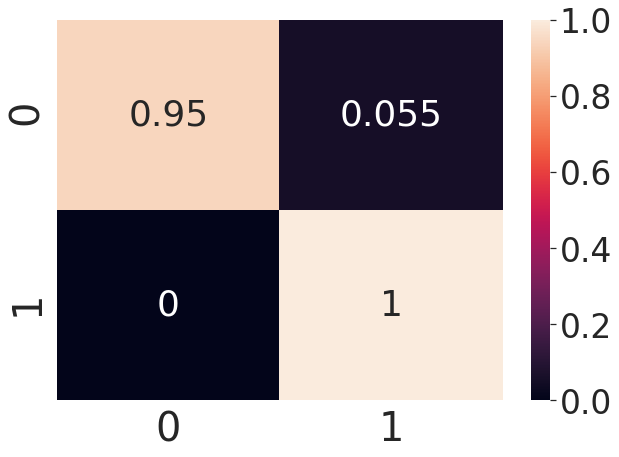

trained on training + val, predicted test


<ipython-input-10-9050486b611c>:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  gbm.fit(x12,y12)


acc on test from Random Forest:  0.7407407407407407
acc on dca set from single tree:  0.375
F1_Mean 0.6842456204158331


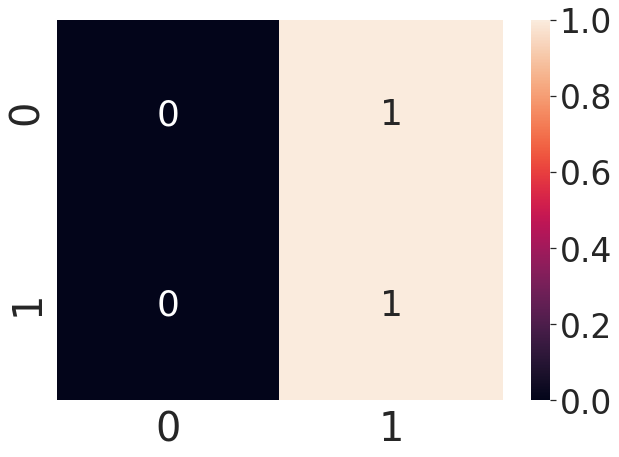

In [11]:
train_randomforest(1)

##Random Forest Dataset: 2##
trained on training, predicted validation


<ipython-input-10-9050486b611c>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  gbm.fit(Xtrain,Ytrain)


acc on val from Random Forest:  0.9421487603305785


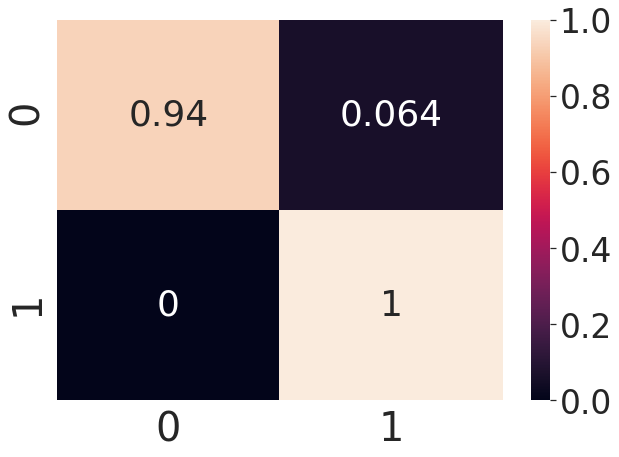

trained on training + val, predicted test


<ipython-input-10-9050486b611c>:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  gbm.fit(x12,y12)


acc on test from Random Forest:  0.7777777777777778
acc on dca set from single tree:  0.375
F1_Mean 0.6951566951566952


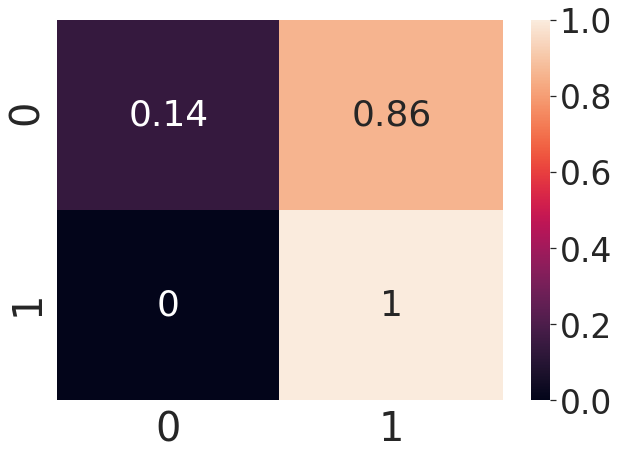

In [12]:
train_randomforest(2)

##Random Forest Dataset: 3##
trained on training, predicted validation


<ipython-input-10-9050486b611c>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  gbm.fit(Xtrain,Ytrain)


acc on val from Random Forest:  0.9387135922330098


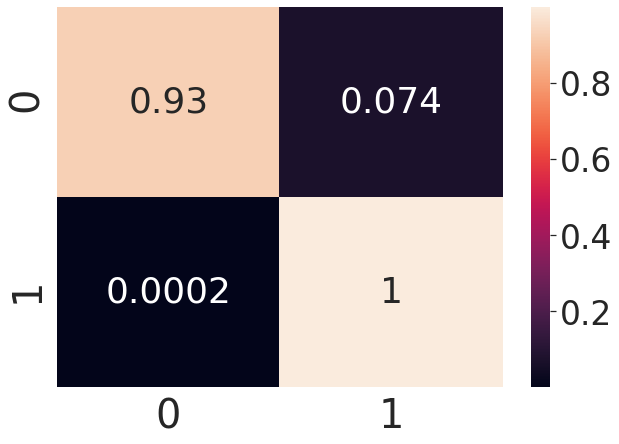

trained on training + val, predicted test


<ipython-input-10-9050486b611c>:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  gbm.fit(x12,y12)


acc on test from Random Forest:  0.7777777777777778
acc on dca set from single tree:  0.4375
F1_Mean 0.7058823529411765


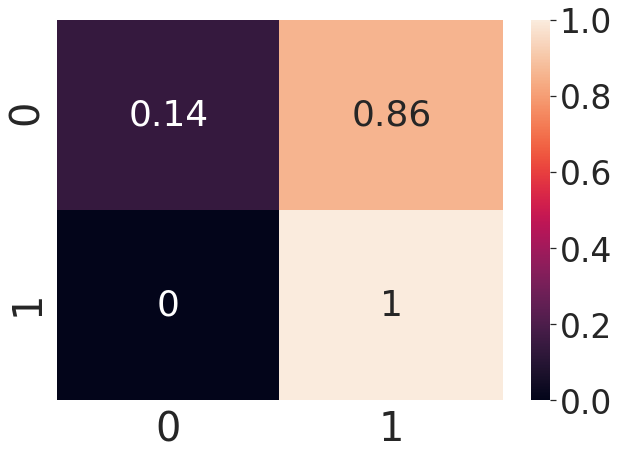

In [13]:
train_randomforest(3)

In [14]:
def boosted(datanum):
    # fit on train, predict on val
    print(f"##Boosted Random Forest Dataset: {datanum}##")
    Xtrain = {1: Xtrain1, 2: Xtrain2, 3:Xtrain3}[datanum]
    Xval = {1: Xval1, 2: Xval2, 3:Xval3}[datanum]
    Ytrain = {1: Ytrain1, 2: Ytrain2, 3:Ytrain3}[datanum]
    Yval = {1: Yval1, 2: Yval2, 3:Yval3}[datanum]
    
    print("trained on training, predicted validation")
    gbm = ske.GradientBoostingRegressor(learning_rate=.2,n_estimators=5000,max_depth=4)
    gbm.fit(Xtrain,Ytrain)
    ytrainboost = gbm.predict(Xval)

    print('acc on val from Gradient Boosted Random Forest: ',acc(Yval.astype('bool'),ytrainboost.astype('bool')))
    
    confusion_matrix(Yval, ytrainboost)
    
    seqs, Xtest, Ytest = get_testset(types[datanum])
    
    ##################################################
    ### let's fit gb on train+val, predict on test
    print("Boosted, trained on training + val, predicted test")
    ## use train and val data
    x12 = np.vstack([Xtrain, Xval])
    y12 = np.concatenate([Ytrain, Yval])

    gbm.fit(x12,y12)
    yhgb3 = gbm.predict(Xtest)
    
    print('acc on test from Gradient Boosted Random Forest: ',acc(Ytest.astype('bool'),yhgb3.astype('bool')))
    
    dcaseqs, Xdca, Ydca = get_dcaset()
    ydca = gbm.predict(Xdca)
    print('acc on dca set from single tree: ',acc(Ydca.astype('bool'), ydca.astype('bool')))
    Ytest = np.asarray(Ytest, dtype="bool")
    Ydca = np.asarray(Ydca, dtype="bool")
    ydca = np.asarray(ydca, dtype="bool")
    yhgb3 = np.asarray(yhgb3, dtype="bool")
    f1_test = skmet.f1_score(Ytest, yhgb3)
    f1_dca = skmet.f1_score(Ydca, ydca)
    f1_mean = (23*f1_test +16*f1_dca)/(23+16)
    print("F1_Mean", f1_mean)

    confusion_matrix(Ytest, yhgb3)
    

##Boosted Random Forest Dataset: 1##
trained on training, predicted validation


/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


acc on val from Gradient Boosted Random Forest:  0.09090909090909091


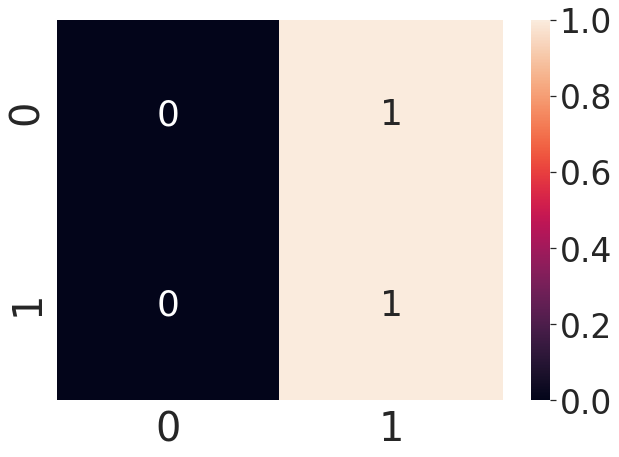

Boosted, trained on training + val, predicted test


/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


acc on test from Gradient Boosted Random Forest:  0.7407407407407407
acc on dca set from single tree:  0.3125
F1_Mean 0.6972696334398462


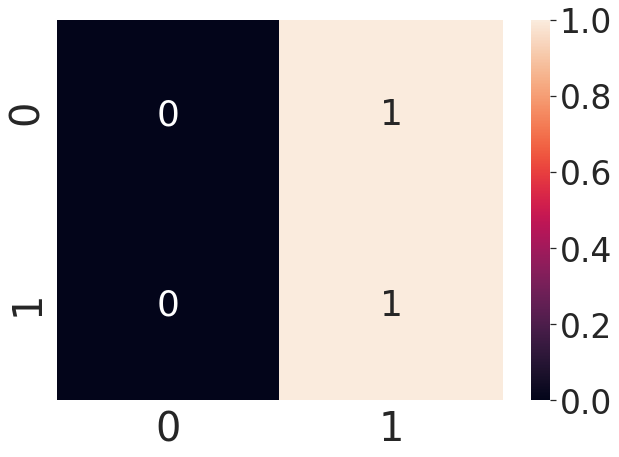

In [15]:
boosted(1)

##Boosted Random Forest Dataset: 2##
trained on training, predicted validation


/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


acc on val from Gradient Boosted Random Forest:  0.09090909090909091


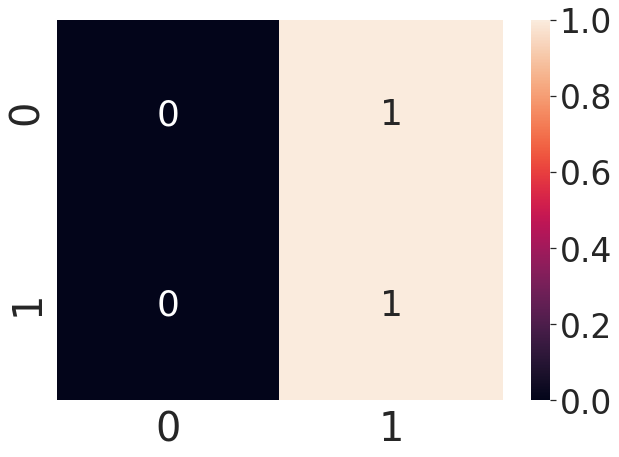

Boosted, trained on training + val, predicted test


/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


acc on test from Gradient Boosted Random Forest:  0.7407407407407407
acc on dca set from single tree:  0.3125
F1_Mean 0.6972696334398462


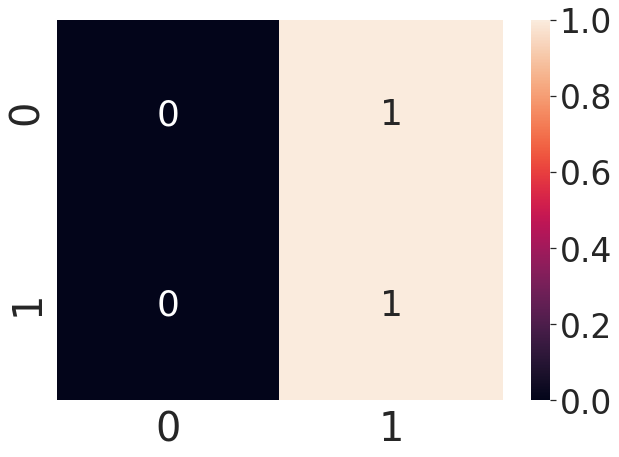

In [16]:
boosted(2)

##Boosted Random Forest Dataset: 3##
trained on training, predicted validation


/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


acc on val from Gradient Boosted Random Forest:  0.16666666666666666


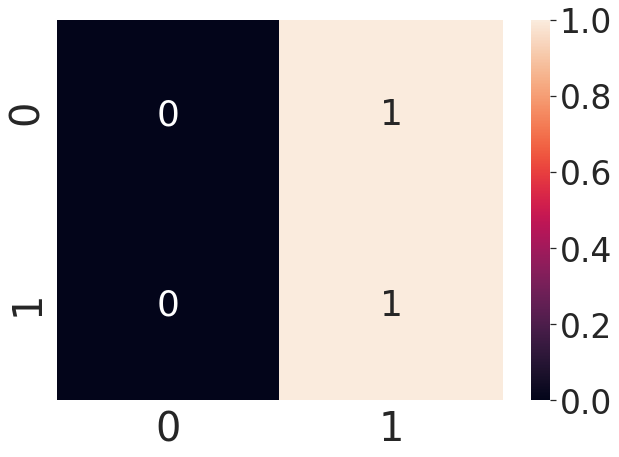

Boosted, trained on training + val, predicted test


/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


acc on test from Gradient Boosted Random Forest:  0.7407407407407407
acc on dca set from single tree:  0.3125
F1_Mean 0.6972696334398462


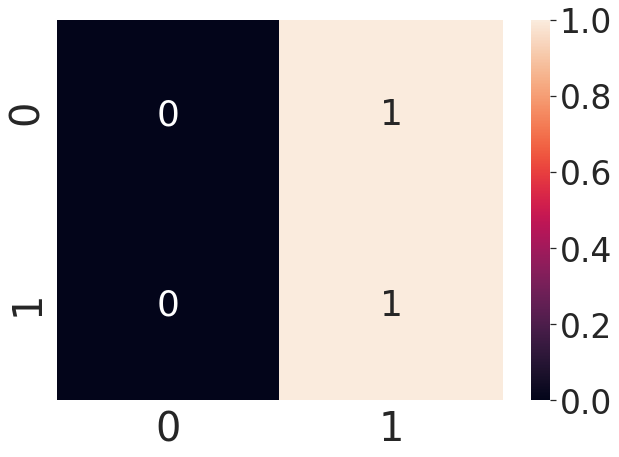

In [17]:
boosted(3)